In [1]:
import warnings
warnings.filterwarnings('ignore')

import configparser
cfg = configparser.ConfigParser()
cfg.optionxform = str
cfg.read('/home/sarth/rootdir/datadir/assets/defaults.ini')
cfg = {s: dict(cfg.items(s)) for s in cfg.sections()}
PATHS = cfg['PATHS']

# import torch
# from torch import nn
import numpy as np
import pandas as pd
import xarray as xr
import networkx as nx
import matplotlib.pyplot as plt
import random
import os
import tqdm
import glob
import itertools
import pickle
import gc
import json
# from torch.utils.data import Dataset, DataLoader

RUN_NAME = 'Run02'
PROJECT_DIR = os.path.join('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025')
ANALYSIS_DIR = os.path.join(PROJECT_DIR, 'analysis', RUN_NAME)
RESULTS_DIR = os.path.join(PROJECT_DIR, 'Results', RUN_NAME)

In [2]:
from scipy import stats, signal

def _mask_valid(pred, true):
    mask = ~np.isnan(true) & ~np.isnan(pred)
    pred = pred[mask]
    true = true[mask]
    pred[pred < 0] = 0
    true[true < 0] = 0
    return pred, true

def RMSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sqrt(np.mean((true - pred)**2))

def pearsonr(pred, true):
    pred, true = _mask_valid(pred, true)
    r, _ = stats.pearsonr(true, pred)
    return r

def NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return 1 - np.sum((true - pred)**2) / np.sum((true - np.mean(true))**2)

def KGE(pred, true):
    pred, true = _mask_valid(pred, true)
    r = pearsonr(pred, true)
    alpha = np.std(pred) / np.std(true)
    beta = np.mean(pred) / np.mean(true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def PBIAS(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sum(true - pred) / np.sum(true) * 100

def alpha_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.std(pred) / np.std(true)

def beta_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return (np.mean(pred) - np.mean(true)) / np.std(true)

def _get_fdc(data):
    data = np.sort(data)[::-1]
    return data

def fdc_fms(pred, true, lower = 0.2, upper = 0.7):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    qsm_lower = np.log(sim[np.round(lower * len(sim)).astype(int)])
    qsm_upper = np.log(sim[np.round(upper * len(sim)).astype(int)])
    qom_lower = np.log(obs[np.round(lower * len(obs)).astype(int)])
    qom_upper = np.log(obs[np.round(upper * len(obs)).astype(int)])

    fms = ((qsm_lower - qsm_upper) - (qom_lower - qom_upper)) / (qom_lower - qom_upper + 1e-6)

    return fms * 100

def fdc_fhv(pred, true, h = 0.02):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)

    obs = obs[:np.round(h * len(obs)).astype(int)]
    sim = sim[:np.round(h * len(sim)).astype(int)]

    fhv = np.sum(sim - obs) / np.sum(obs)

    return fhv * 100

def fdc_flv(pred, true, l = 0.3):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    obs = obs[-np.round(l * len(obs)).astype(int):]
    sim = sim[-np.round(l * len(sim)).astype(int):]

    # transform values to log scale
    obs = np.log(obs)
    sim = np.log(sim)

    # calculate flv part by part
    qsl = np.sum(sim - sim.min())
    qol = np.sum(obs - obs.min())

    flv = -1 * (qsl - qol) / (qol + 1e-6)

    return flv * 100

def mean_peak_timing(pred, true, window = 3):
    pred, true = _mask_valid(pred, true)

    peaks, _ = signal.find_peaks(true, distance=2*window, prominence=np.std(true))

    # pred_idx_lst = []
    timing_error_lst = []
    for idx in peaks:
        if (pred[idx] > pred[idx - 1]) and (pred[idx] > pred[idx + 1]):
            peak_pred = pred[idx]
            peak_pred_idx = idx
        else:
            peak_pred_idx = np.argmax(pred[max(idx - window,0):idx + window + 1]) + max(idx - window,0)
            peak_pred = pred[peak_pred_idx]
        # pred_idx_lst.append(peak_pred_idx)
    
        peak_true = true[idx]
        timing_error = np.abs(peak_pred_idx - idx) 
        timing_error_lst.append(timing_error)
    
    mean_timing_error = np.mean(timing_error_lst) if len(timing_error_lst) > 0 else np.nan

    return mean_timing_error

def missed_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    missed_events = 0
    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) == 0:
            missed_events += 1
            # print(idx)
    
    missed_peak_values = (missed_events / len(peaks_obs_times)) * 100 if len(peaks_obs_times) > 0 else np.nan

    return missed_peak_values

def F1_score_of_capturing_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    true_positive_peaks = 0 # peak in obs and nearby in sim
    true_negative_peaks = 0 # no peak in obs and sim
    false_positive_peaks = 0 # peak in sim but not nearby in obs
    false_negative_peaks = 0 # peak in obs but not nearby in sim

    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) > 0:
            true_positive_peaks += 1
        else:
            false_negative_peaks += 1
    
    for idx in peaks_sim_times:
        nearby_peak_obs_index = np.where(np.abs(peaks_obs_times - idx) <= window)[0]
        if len(nearby_peak_obs_index) == 0:
            false_positive_peaks += 1

    precision = true_positive_peaks / (true_positive_peaks + false_positive_peaks) if (true_positive_peaks + false_positive_peaks) > 0 else np.nan
    recall = true_positive_peaks / (true_positive_peaks + false_negative_peaks) if (true_positive_peaks + false_negative_peaks) > 0 else np.nan
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan

    return f1_score

In [3]:
suffix = 'pred_glofas' # 'pred_gauge' or 'glofas_gauge' or 'pred_glofas'
varname = 'NSE'
lead_time = 1
min_max = None
HUCs = [str(i).zfill(2) for i in range(1, 18+1)]

In [18]:
y_true = np.load('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025/analysis/Run02/evaluations/HUC01/HUC01/y_ground_truth.npy')
y_pred = np.load(f'/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025/analysis/Run02/evaluations/HUC01/HUC01/y_predictions.npy')
print(y_true.shape, y_pred.shape)
lead_time = 1
y_true = y_true[:, lead_time-1, :]
y_pred = y_pred[:, lead_time-1, :]
print(y_true.shape, y_pred.shape)

F1 = [F1_score_of_capturing_peaks(y_pred[:,i], y_true[:,i], window = 3, threshold = 80) for i in range(y_true.shape[1])]
F1

(3650, 7, 12) (3650, 7, 12)
(3650, 12) (3650, 12)


[0.9365853658536586,
 0.8,
 0.9107142857142857,
 0.672340425531915,
 0.8484848484848484,
 0.10945273631840798,
 0.7891891891891892,
 0.8447653429602888,
 0.7885714285714285,
 0.7741935483870969,
 0.9137931034482759,
 0.8780487804878048]

In [15]:
ds = xr.open_dataset('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025/analysis/Run02/evaluations/HUC01/HUC01/metrics_pred_glofas.nc')
ds

<xarray.Dataset> Size: 4kB
Dimensions:      (lead_time: 7, catmt_idx: 12)
Coordinates:
  * lead_time    (lead_time) int64 56B 1 2 3 4 5 6 7
  * catmt_idx    (catmt_idx) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    NSE          (lead_time, catmt_idx) float64 672B ...
    KGE          (lead_time, catmt_idx) float64 672B ...
    PBIAS        (lead_time, catmt_idx) float64 672B ...
    correlation  (lead_time, catmt_idx) float64 672B ...
    rmse         (lead_time, catmt_idx) float64 672B ...

In [4]:
from matplotlib import category
import numpy as np
import os
import xarray as xr

import matplotlib.pyplot as plt

In [5]:
def plot_heatmap(varname, suffix = 'pred_glofas', lead_time = 1, min_max = None, cmap = 'coolwarm_r'):
    HUCs = [str(i).zfill(2) for i in range(1, 18+1)]

    fontsize_tick = 12
    fontsize_label = 16

    df = pd.DataFrame(index=HUCs, columns=HUCs)

    for model_huc in HUCs:
        metric_values = []
        for prediction_huc in HUCs:
            # if not varname == 'F1':
            if not 'F1' in varname:
                ds = xr.open_dataset(os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', f'metrics_{suffix}.nc'))
                ds = ds.sel(lead_time=lead_time)[varname].values
                ds = np.nanmedian(ds)
                metric_values.append(ds)
            else:
                y_true = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', 'y_ground_truth.npy'))
                y_pred = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', 'y_predictions.npy'))
                y_true = y_true[:, lead_time-1, :]
                y_pred = y_pred[:, lead_time-1, :]
                F1 = [F1_score_of_capturing_peaks(y_pred[:,i], y_true[:,i], window = 3, threshold = 80) for i in range(y_true.shape[1])]
                F1 = np.nanmedian(F1)
                metric_values.append(F1)
        df[model_huc] = metric_values

    df.index.name = 'Model HUC'
    df.columns.name = 'Prediction HUC'

    # # Clip values below -10
    # df = df.clip(lower=-10)

    # Set values below -10 to NaN
    # df[df < -1] = np.nan

    cmap = plt.cm.get_cmap(cmap).copy()
    # cmap.set_bad(color='black')

    plt.figure(figsize=(10, 8), dpi = 600)
    if min_max is not None:
        plt.pcolor(df, cmap=cmap, edgecolors='k', linewidths=0.5, vmin = min_max[0], vmax = min_max[1])
    else:
        plt.pcolor(df, cmap=cmap, edgecolors='k', linewidths=0.5)
    cbar = plt.colorbar(extend='min')
    cbar.ax.tick_params(labelsize=fontsize_tick, rotation=0)
    cbar.set_label(varname, fontsize=fontsize_label)
    plt.xticks(ticks=np.arange(len(HUCs)) + 0.5, labels=HUCs, rotation=45, fontsize=fontsize_tick)
    plt.yticks(ticks=np.arange(len(HUCs)) + 0.5, labels=HUCs, fontsize=fontsize_tick)
    # plt.title(f'{varname} Heatmap for Lead Time {lead_time}')
    plt.tight_layout()
    plt.xlabel('Prediction HUC', fontsize=fontsize_label)
    plt.ylabel('Model HUC', fontsize=fontsize_label)
    plt.show()

    return df

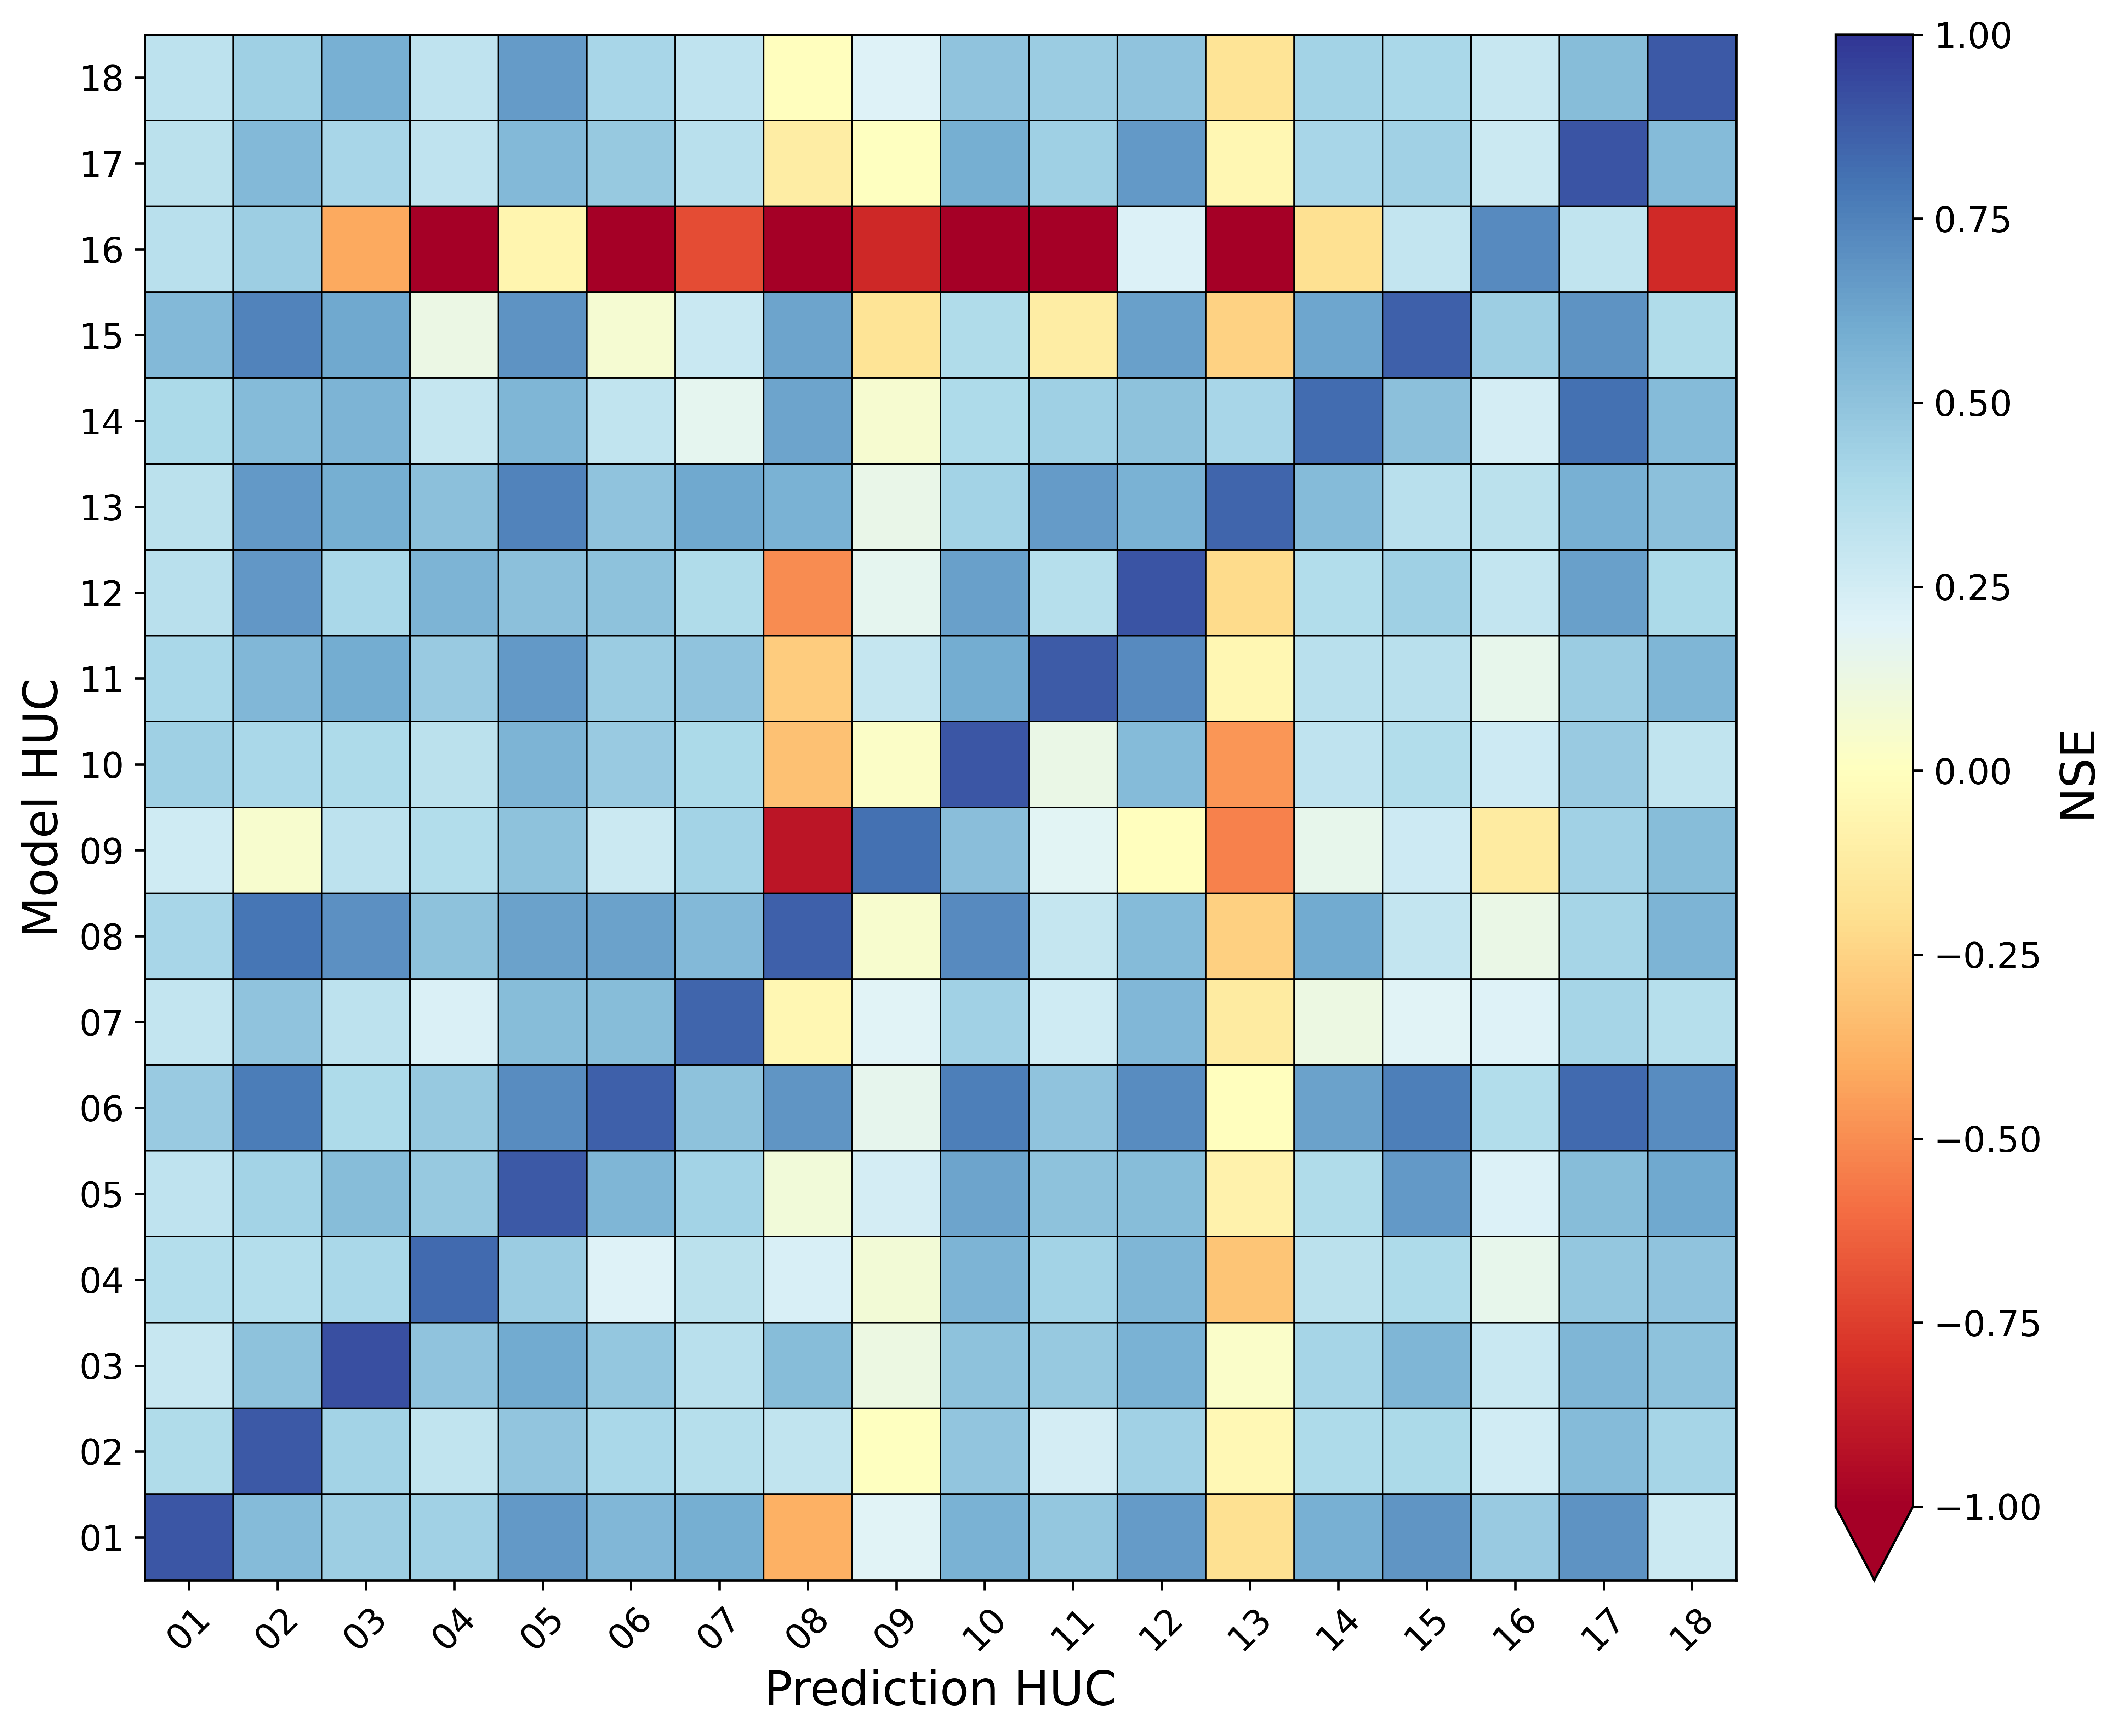

In [45]:
_ = plot_heatmap('NSE', suffix='pred_glofas', lead_time=1, cmap = 'RdYlBu', min_max = [-1, 1])

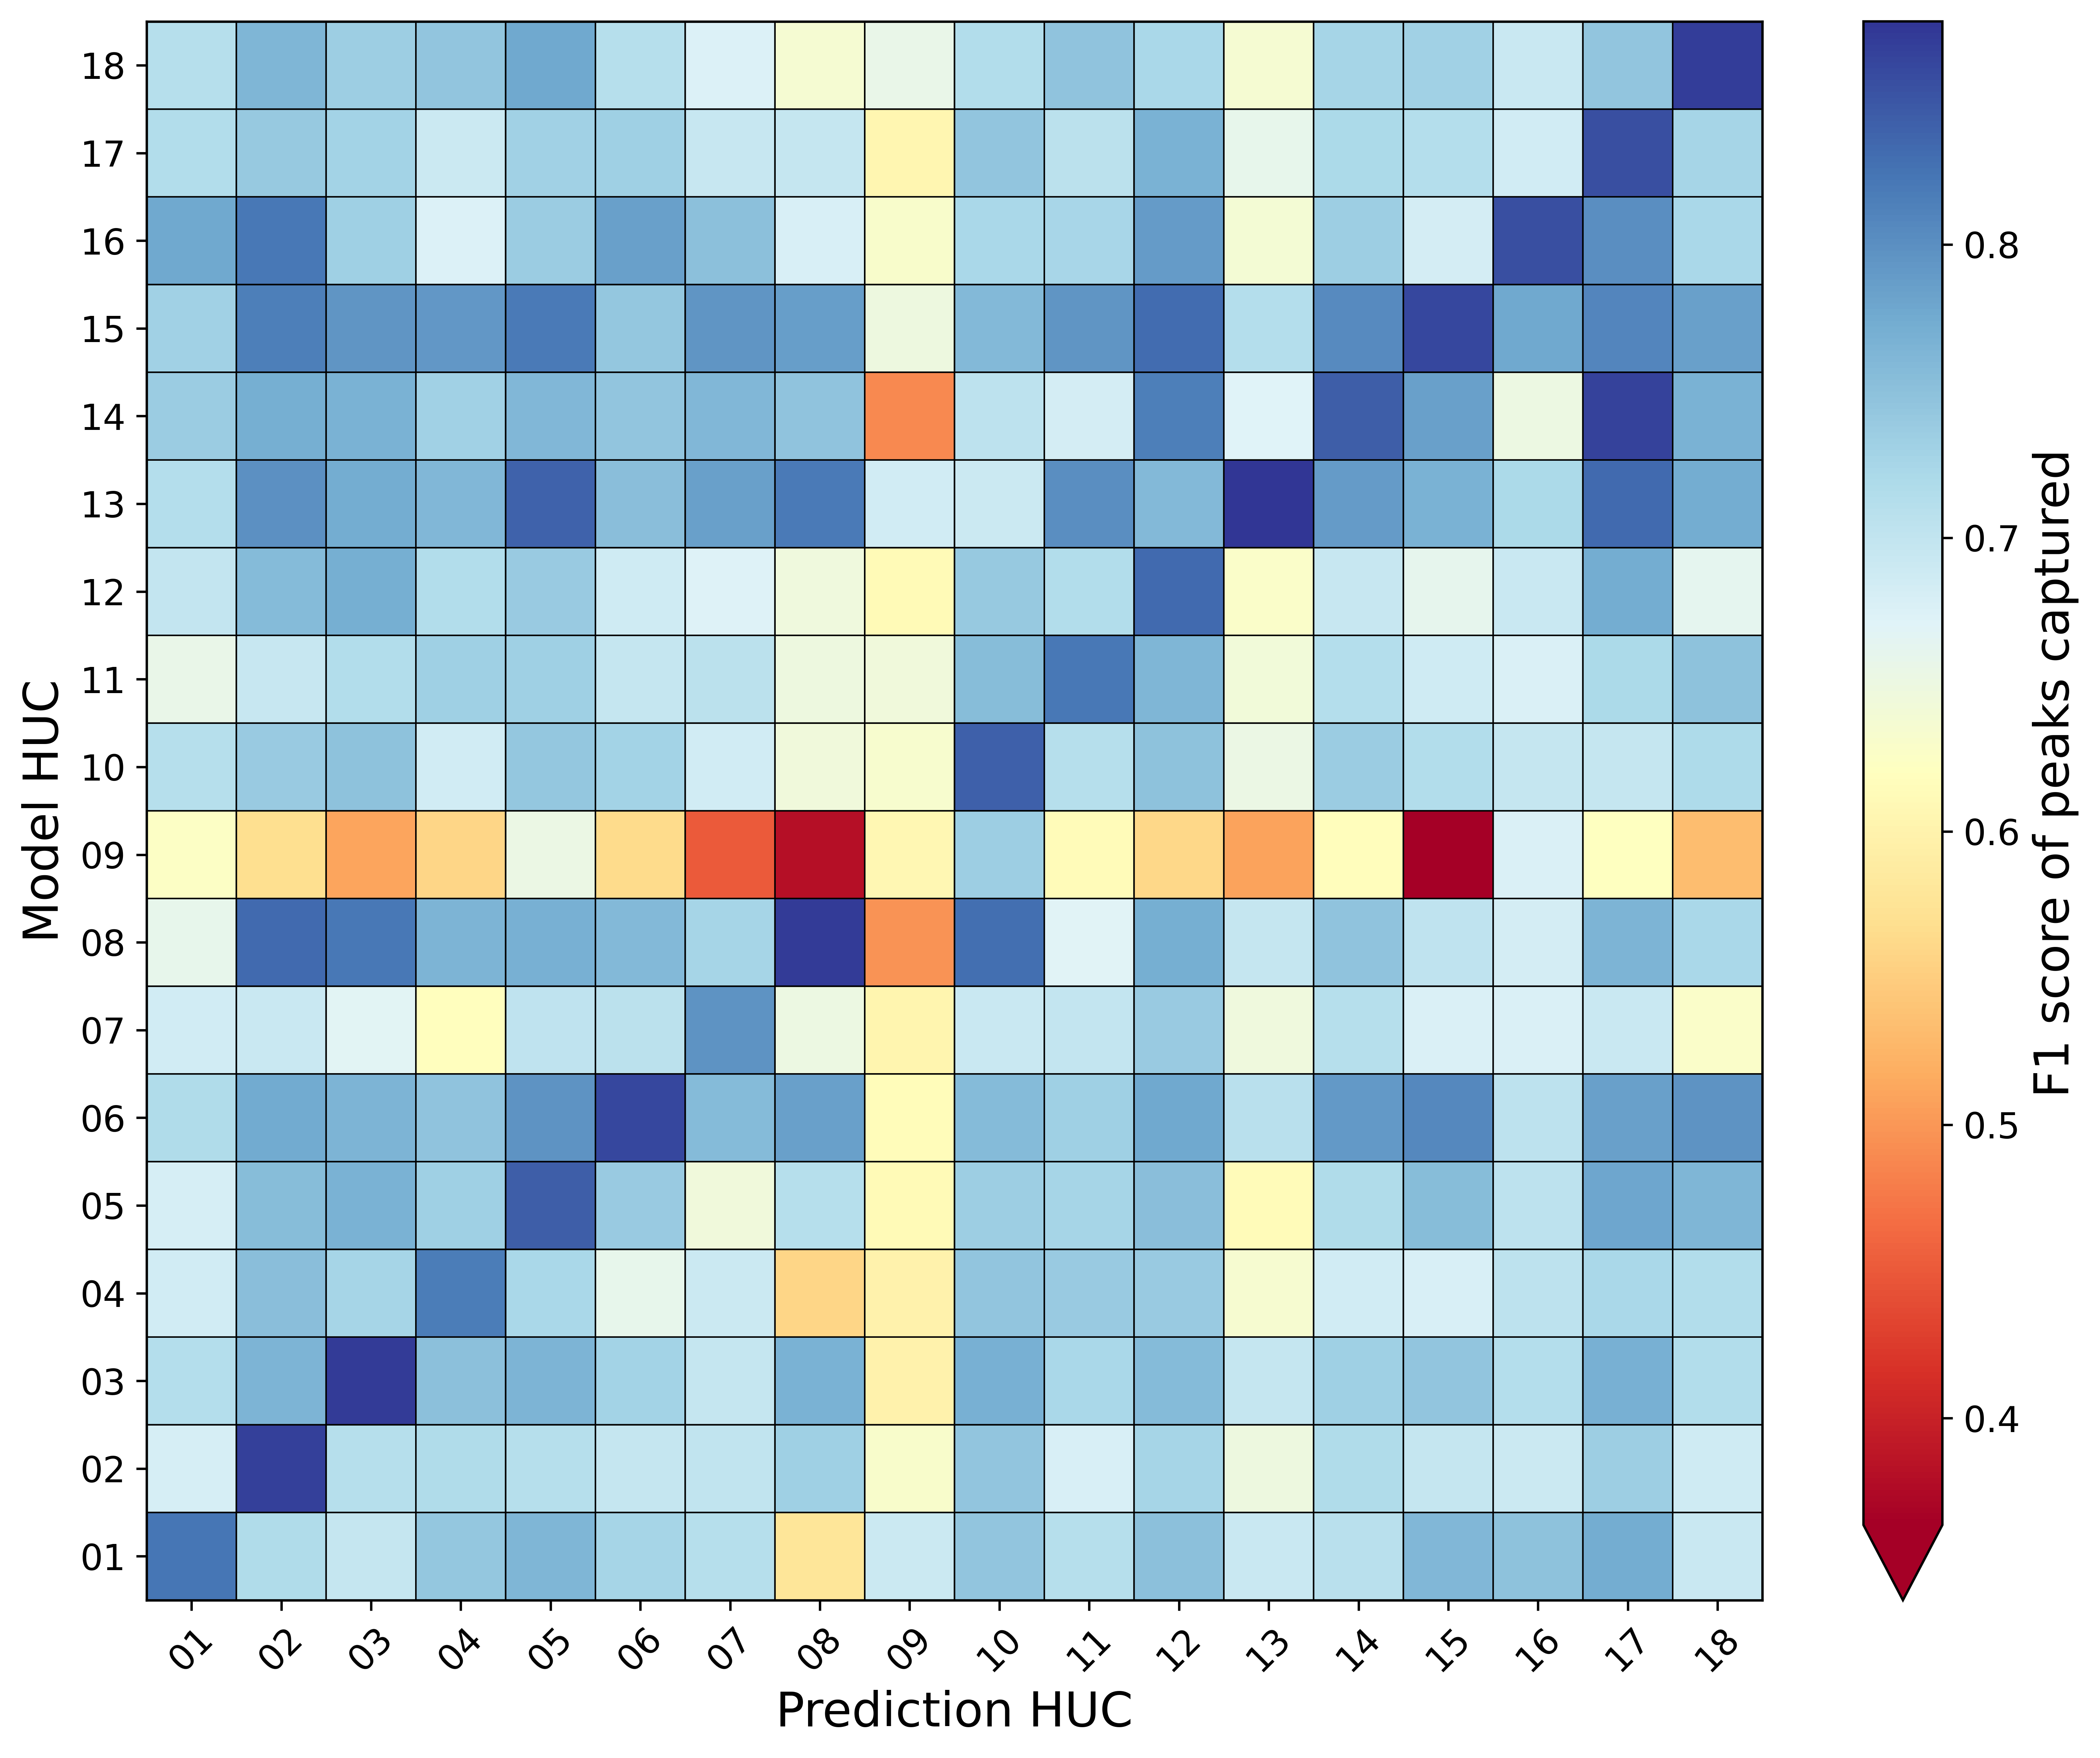

In [48]:
_ = plot_heatmap('F1 score of peaks captured', suffix='pred_glofas', lead_time=1, cmap = 'RdYlBu')#, min_max = [0, 1])

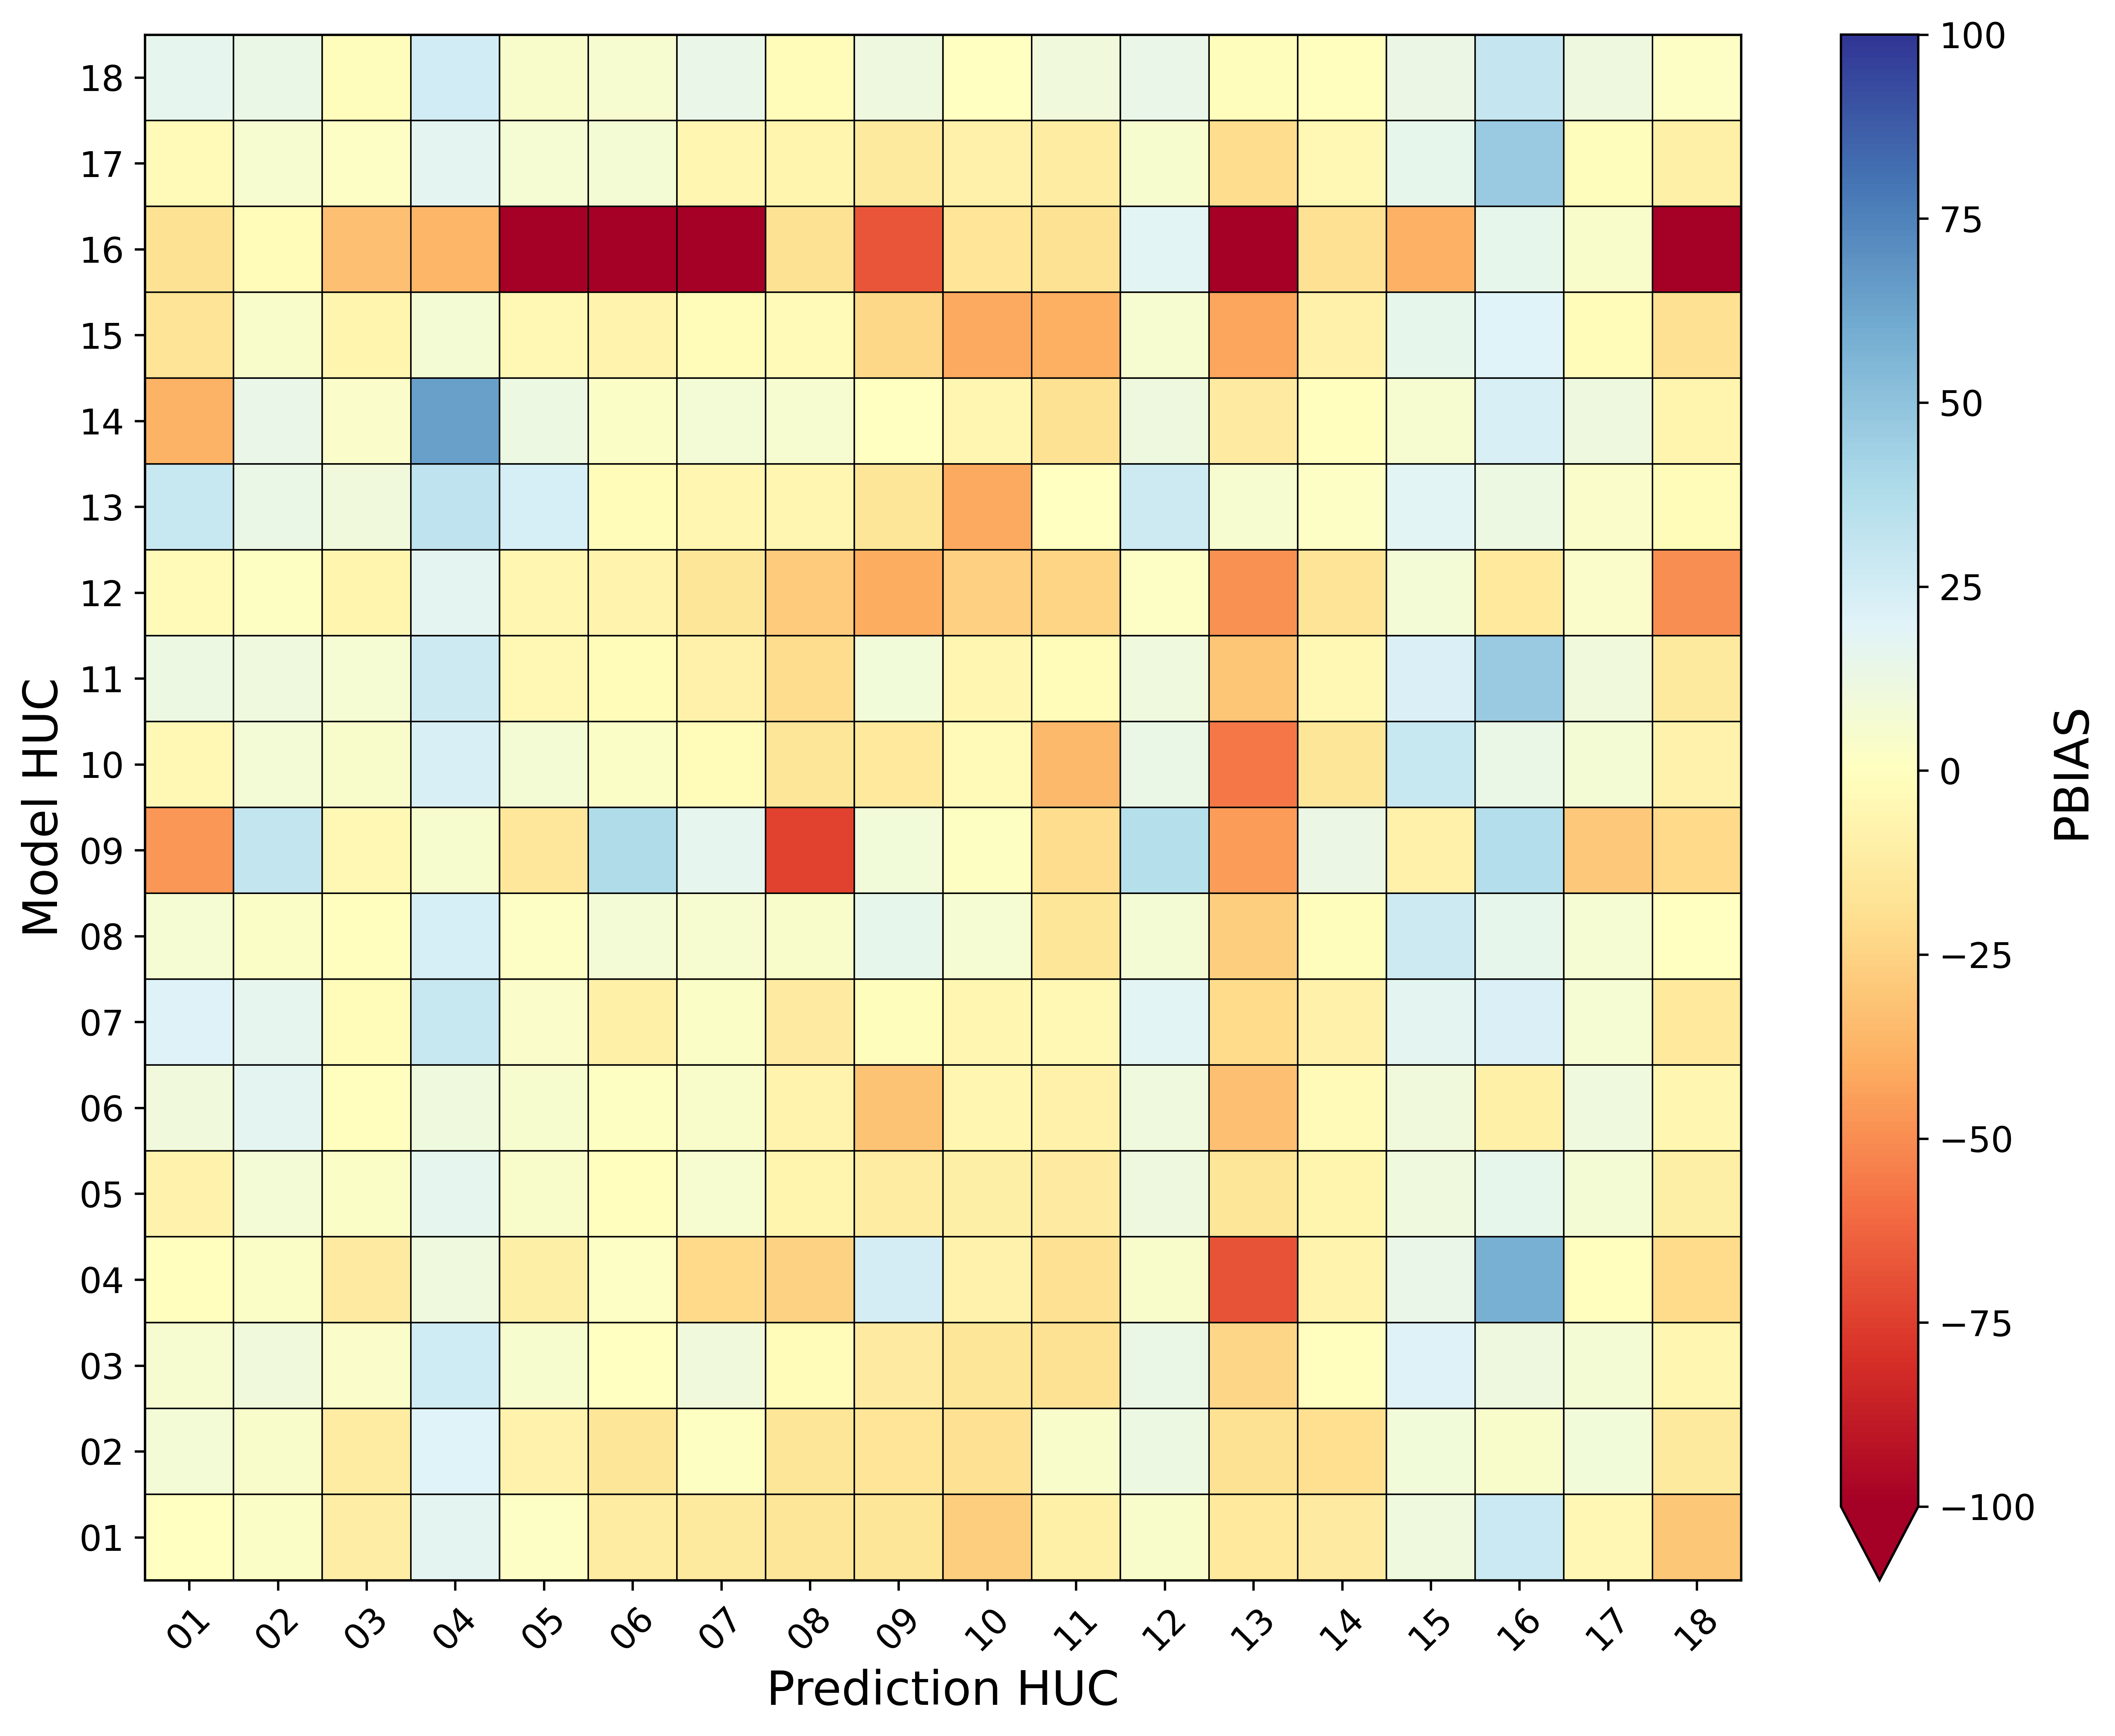

In [6]:
_ = plot_heatmap('PBIAS', suffix='pred_glofas', lead_time=1, cmap = 'RdYlBu', min_max = [-100, 100])

In [28]:
def plot_radar(varname, suffix='pred_glofas', lead_time=1, min_max=None, cmap='tab20', filled=False):
    # Use the global HUCs (predicted hucs)
    spokes = HUCs  # ['01', '02', ..., '18']
    n_spokes = len(spokes)
    
    # Create angles for radar plot (and close the circular loop).
    angles = np.linspace(0, 2 * np.pi, n_spokes, endpoint=False).tolist()
    angles += angles[:1]  # close circle
    
    # Prepare the figure
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)
    
    # Prepare colormap for consistent colors
    color_map = plt.cm.get_cmap(cmap, len(HUCs))
    
    # For legend handles
    lines = []
    
    # Loop over each model HUC (each line corresponds to one model HUC)
    for i, model_huc in enumerate(HUCs):
        metrics = []
        # Loop over predicted HUCs (spokes)
        for prediction_huc in HUCs:
            if varname != 'F1':
                # load dataset and select the metric (median across catmt_idx)
                nc_path = os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', f'metrics_{suffix}.nc')
                ds_tmp = xr.open_dataset(nc_path)
                # select metric value for given lead_time
                val = ds_tmp.sel(lead_time=lead_time)[varname].values
                val = np.nanmedian(val)
                metrics.append(val)
            else:
                # for F1, load predictions and ground truth and compute metric
                y_true = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', 'y_ground_truth.npy'))
                y_pred = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f'HUC{model_huc}', f'HUC{prediction_huc}', 'y_predictions.npy'))
                y_true = y_true[:, lead_time-1, :]
                y_pred = y_pred[:, lead_time-1, :]
                F1_vals = [F1_score_of_capturing_peaks(y_pred[:, j], y_true[:, j], window=3, threshold=80) for j in range(y_true.shape[1])]
                metrics.append(np.nanmedian(F1_vals))
        
        # Close the metrics to complete the loop on radar
        metrics += metrics[:1]
        
        # Optionally clip values based on min_max if provided
        if min_max is not None:
            metrics = [max(min(val, min_max[1]), min_max[0]) for val in metrics]
        
        # Plot line with color from colormap
        line, = ax.plot(angles, metrics, color=color_map(i), linewidth=2, label=f'{model_huc}')
        lines.append(line)
        # Optionally fill area under the radar curve
        if filled:
            ax.fill(angles, metrics, color=color_map(i), alpha=0.25)
    
    # Set the labels for each spoke
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(spokes, fontsize=12)
    
    # Optional: set radial grid labels and limits based on min_max
    if min_max is not None:
        ax.set_ylim(min_max)
    ax.tick_params(axis='y', labelsize=10)
    
    # Add legend & title
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1), fontsize=10, title='Model HUC')
    plt.title(f'Predicted HUC', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    return None



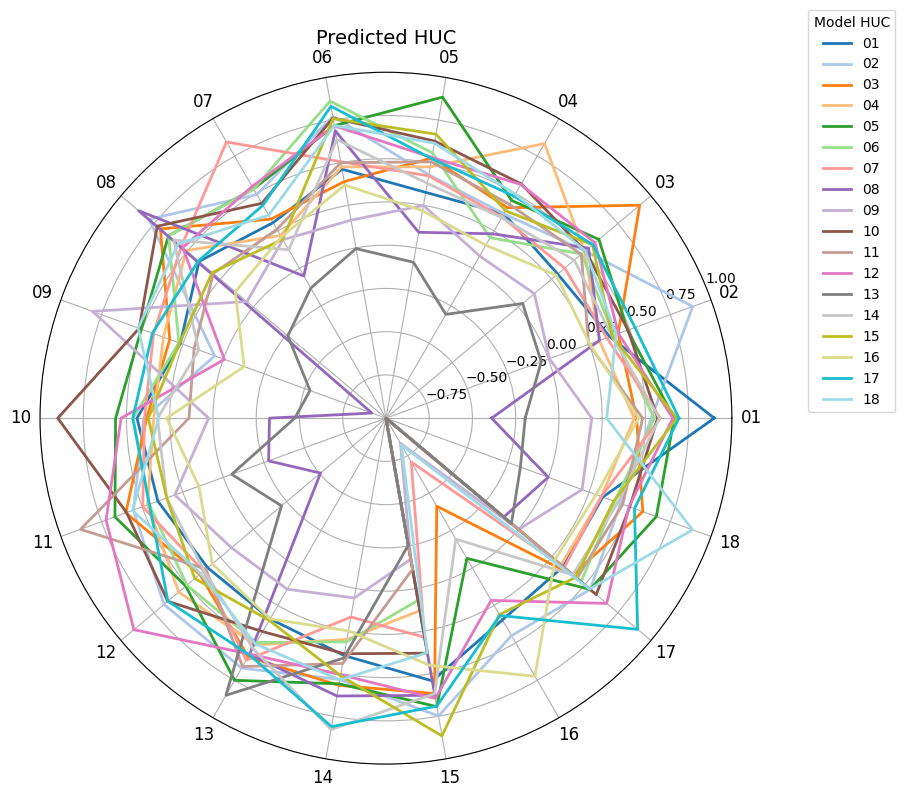

In [30]:
_ = plot_radar('NSE', suffix='pred_glofas', lead_time=1, min_max=[-1, 1], cmap='tab20', filled=False)

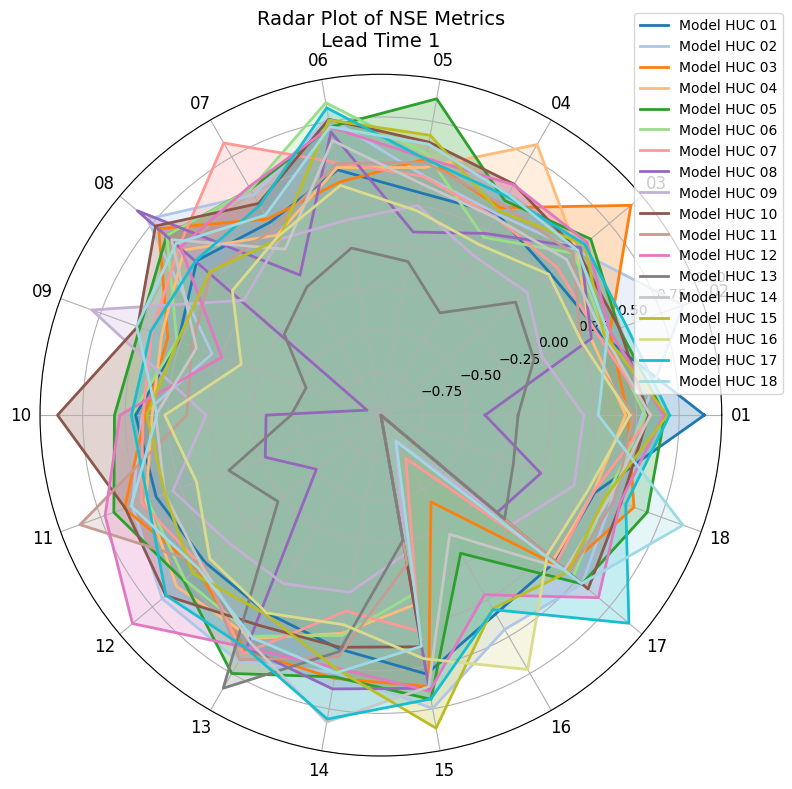

In [ ]:
_ = plot_radar('NSE', suffix='pred_glofas', lead_time=1, min_max=[-1, 1], cmap='tab20', filled=False)